# Tutorial 4: Use SEDR to process Stereo-seq data

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns

import os
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from scipy.sparse import csr_matrix

/home/lytq/.conda/envs/SEDR/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/lytq/.conda/envs/SEDR/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/lytq/.conda/envs/SEDR/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/lytq/.conda/envs/SEDR/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/lytq/.conda/envs/SEDR/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is dep

In [2]:
import SEDR

random_seed = 2023
SEDR.fix_seed(random_seed)

### Loading data

In [2]:
data_root = Path('/home/lytq/Spatial-Transcriptomics-Benchmark/data/Mouse_Olfactory_Bulb')

In [15]:
save_path = '/home/lytq/Spatial-Transcriptomics-Benchmark/RESULTS/Mouse_Olfactory_Bulb/SEDR'

os.makedirs(save_path, exist_ok=True)

In [3]:
if not os.path.exists(data_root / 'raw.h5ad'):
    counts = pd.read_csv(data_root / 'RNA_counts.tsv.gz', sep='\t', index_col=0).T
    counts.index = [f'Spot_{i}' for i in counts.index]
    adata = sc.AnnData(counts)
    adata.X = csr_matrix(adata.X, dtype=np.float32)

    df_pos = pd.read_csv(data_root / 'position.tsv', sep='\t')
    adata.obsm['spatial'] = df_pos[['y','x']].values
    
    used_barcode = pd.read_csv(os.path.join(data_root / 'used_barcodes.txt'), sep='\t', header=None)
    used_barcode = used_barcode[0]
    adata = adata[used_barcode,]
    
    adata.write( data_root / 'raw.h5ad')
else:
    adata = sc.read_h5ad( data_root / 'raw.h5ad')

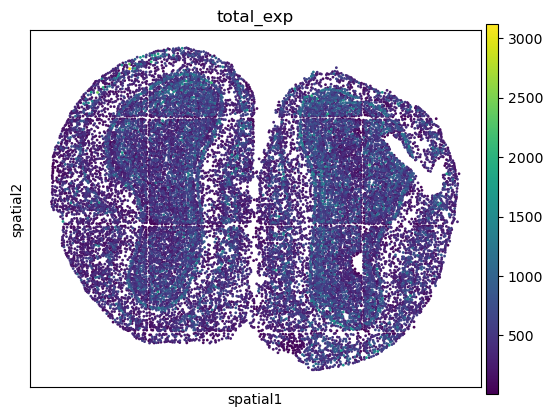

In [5]:
adata.obs['total_exp'] = adata.X.sum(axis=1)
fig, ax = plt.subplots()
sc.pl.spatial(adata, color='total_exp', spot_size=40, show=False, ax=ax)
ax.invert_yaxis()

### Preprocessing

In [6]:
adata.layers['count'] = adata.X.toarray()
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.scale(adata)

from sklearn.decomposition import PCA
adata_X = PCA(n_components=200, random_state=42).fit_transform(adata.X)
adata.obsm['X_pca'] = adata_X

# construct graph
graph_dict = SEDR.graph_construction(adata, 6)

In [7]:
adata

AnnData object with n_obs × n_vars = 19109 × 27106
    obs: 'total_exp'
    var: 'mean', 'std'
    obsm: 'spatial', 'X_pca'
    layers: 'count'

In [8]:
adata.obs

,total_exp
Spot_1,490.842621
Spot_10,240.722229
Spot_100,189.000000
Spot_1000,212.833328
Spot_10000,386.515137
...,...
Spot_9994,325.076904
Spot_9995,261.500000
Spot_9996,388.083313
Spot_9998,136.833344


### Running SEDR

In [9]:
sedr_net = SEDR.Sedr(adata.obsm['X_pca'], graph_dict, device='cuda:0')
using_dec = True
if using_dec:
    sedr_net.train_with_dec()
else:
    sedr_net.train_without_dec()
sedr_feat, _, _, _ = sedr_net.process()
adata.obsm['SEDR'] = sedr_feat

100%|██████████| 200/200 [00:06<00:00, 30.16it/s]


In [10]:
adata

AnnData object with n_obs × n_vars = 19109 × 27106
    obs: 'total_exp'
    var: 'mean', 'std'
    obsm: 'spatial', 'X_pca', 'SEDR'
    layers: 'count'

### Clustering

In [11]:
n_clusters = 7
SEDR.mclust_R(adata, n_clusters, use_rep='SEDR', key_added='SEDR')

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


AnnData object with n_obs × n_vars = 19109 × 27106
    obs: 'total_exp', 'SEDR'
    var: 'mean', 'std'
    obsm: 'spatial', 'X_pca', 'SEDR'
    layers: 'count'

In [12]:
adata.obs

,total_exp,SEDR
Spot_1,490.842621,7
Spot_10,240.722229,7
Spot_100,189.000000,7
Spot_1000,212.833328,2
Spot_10000,386.515137,7
...,...,...
Spot_9994,325.076904,7
Spot_9995,261.500000,7
Spot_9996,388.083313,7
Spot_9998,136.833344,2


In [13]:
adata.obs['SEDR'].value_counts

<bound method IndexOpsMixin.value_counts of Spot_1        7
Spot_10       7
Spot_100      7
Spot_1000     2
Spot_10000    7
             ..
Spot_9994     7
Spot_9995     7
Spot_9996     7
Spot_9998     2
Spot_9999     7
Name: SEDR, Length: 19109, dtype: category
Categories (7, int64): [1, 2, 3, 4, 5, 6, 7]>

### Visualization

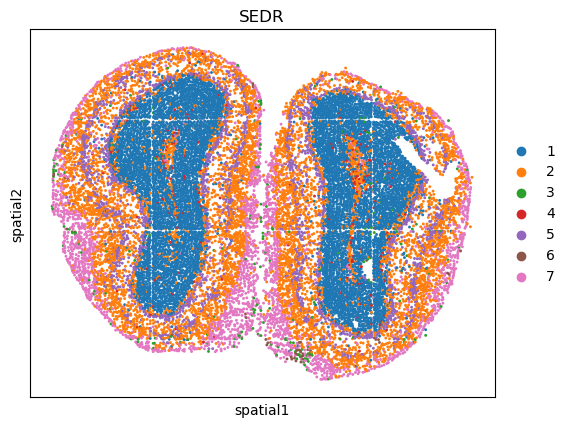

In [16]:
fig, ax = plt.subplots(1,1,figsize=(6, 6))
sc.pl.spatial(adata, color='SEDR', spot_size=40, show=False, ax=ax)
ax.invert_yaxis()

plt.savefig(os.path.join(save_path, 'clustering.pdf'), dpi=300, bbox_inches='tight')

In [18]:
adata.obs

,total_exp,SEDR
Spot_1,490.842621,7
Spot_10,240.722229,7
Spot_100,189.000000,7
Spot_1000,212.833328,2
Spot_10000,386.515137,7
...,...,...
Spot_9994,325.076904,7
Spot_9995,261.500000,7
Spot_9996,388.083313,7
Spot_9998,136.833344,2


#### Each cluster

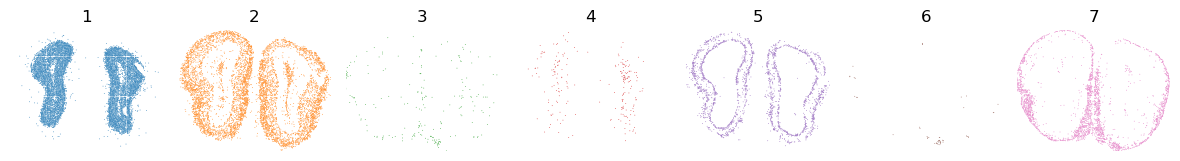

In [33]:
fig, axes = plt.subplots(1, n_clusters,figsize=(1.7*n_clusters, 1.5*2), sharex=True, sharey=True)
axes = axes.ravel()

for i in range(n_clusters):
    sub = adata[adata.obs['SEDR'] == i+1]
    sc.pl.spatial(sub, spot_size=30, color='SEDR', ax=axes[i], legend_loc=None, show=False)
    axes[i].set_title(i+1)
    
xmin = adata.obsm['spatial'][:, 0].min()
xmax = adata.obsm['spatial'][:, 0].max()
ymin = adata.obsm['spatial'][:, 1].min()
ymax = adata.obsm['spatial'][:, 1].max()

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    
plt.subplots_adjust(wspace=0, hspace=0.05)
plt.tight_layout()
plt.savefig(save_path + '/each_cluster.pdf', dpi=300, bbox_inches='tight')

In [24]:
file_path = '/home/lytq/Spatial-Transcriptomics-Benchmark/data/Mouse_Olfactory_Bulb/' 

In [25]:
counts_file = os.path.join(file_path, 'RNA_counts.tsv.gz')
coords_file = os.path.join(file_path, 'position.tsv')
counts = pd.read_csv(counts_file, sep='\t', index_col=0)
coords = pd.read_csv(coords_file, sep='\t')

In [26]:
counts.columns = ['Spot_'+str(x) for x in counts.columns]
coords.index = coords['label'].map(lambda x: 'Spot_'+str(x))
coords = coords.loc[:, ['x','y']]

In [27]:
coords = coords.loc[adata.obs_names, ['y', 'x']]
adata.obs['x'] = coords['x']
adata.obs['y'] = coords['y']
adata.obsm['spatial'] = coords.to_numpy()

In [28]:
used_barcode = pd.read_csv(os.path.join(file_path, 'used_barcodes.txt'), sep='\t', header=None)
used_barcode = used_barcode[0]
used_barcode

0            Spot_1
1           Spot_10
2          Spot_100
3         Spot_1000
4        Spot_10000
            ...    
19104     Spot_9994
19105     Spot_9995
19106     Spot_9996
19107     Spot_9998
19108     Spot_9999
Name: 0, Length: 19109, dtype: object

In [29]:
adata = adata[used_barcode,]
adata

View of AnnData object with n_obs × n_vars = 19109 × 27106
    obs: 'total_exp', 'SEDR', 'x', 'y'
    var: 'mean', 'std'
    uns: 'SEDR_colors'
    obsm: 'spatial', 'X_pca', 'SEDR'
    layers: 'count'

In [30]:
cell_metadata = adata.obs
cell_metadata

,total_exp,SEDR,x,y
Spot_1,490.842621,7,12555.007833,6307.537859
Spot_10,240.722229,7,12806.715054,6311.983871
Spot_100,189.000000,7,12752.469565,6425.617391
Spot_1000,212.833328,2,12545.601942,6856.786408
Spot_10000,386.515137,7,12993.429134,9153.204724
...,...,...,...,...
Spot_9994,325.076904,7,14127.819588,9148.005155
Spot_9995,261.500000,7,12933.872611,9147.484076
Spot_9996,388.083313,7,13328.963303,9155.389908
Spot_9998,136.833344,2,12637.854167,9150.281250


In [32]:
cell_metadata.to_csv(save_path + '/cell_metadata.csv')